In [55]:
import os
import urllib.request
import json
import xml.etree.ElementTree as ET
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import selectivesearch

In [56]:
def load_dataset(root_dir, split_ratio=0.8):
    """
    Load dataset from the given root directory
    Args:
        root_dir: Root directory containing annotated-images folder
        split_ratio: Ratio of training set (default 0.8)
    Returns:
        train_images, train_annotations lists
    """
    images_dir = os.path.join(root_dir, 'annotated-images')
    
    # Get all image files
    image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]
    
    # Get corresponding annotation files
    image_and_annos = []
    for img_file in image_files:
        base_name = img_file[:-4]  # Remove .jpg
        xml_file = os.path.join(images_dir, base_name + '.xml')
        if os.path.exists(xml_file):
            image_and_annos.append((
                os.path.join(images_dir, img_file),
                xml_file
            ))
    
    # Shuffle and split
    np.random.shuffle(image_and_annos)
    split_idx = int(len(image_and_annos) * split_ratio)
    train_set = image_and_annos[:split_idx]
    
    # Separate into images and annotations lists
    train_images, train_annotations = zip(*train_set)
    
    return list(train_images), list(train_annotations)

In [57]:
class ProposalGenerator:
    def __init__(self):
        pass
        
    def preprocess_image(self, image, max_size=1000):
        height, width = image.shape[:2]
        if max(height, width) > max_size:
            scale_factor = max_size / max(height, width)
            new_height = int(height * scale_factor)
            new_width = int(width * scale_factor)
            image = cv2.resize(image, (new_width, new_height))
        return image, scale_factor if max(height, width) > max_size else 1.0

    def selective_search_fast(self, image):
        # Convert BGR to RGB
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
        # Compute selective search proposals
        ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
        ss.setBaseImage(image_rgb)
        ss.switchToSelectiveSearchFast()  # Use fast mode
    
        # Get proposals
        boxes = ss.process()
    
        # Convert to [x1, y1, x2, y2] format
        proposals = []
        for x, y, w, h in boxes:
            proposals.append([x, y, x+w, y+h])
    
        return proposals[:3000]

    def edge_boxes(self, image, max_boxes=3000, min_score=0.01):

        # Preprocess image
        image, scale_factor = self.preprocess_image(image)
    
        # Convert to RGB if necessary
        if len(image.shape) == 3 and image.shape[2] == 3:
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        else:
            image_rgb = image

        # Create edge boxes detector
        edge_boxes = cv2.ximgproc.createEdgeBoxes()
        edge_boxes.setMaxBoxes(max_boxes)
        edge_boxes.setMinScore(min_score)

        # Detect edges using Canny
        edges = cv2.Canny(image_rgb, 50, 150)
        edges = edges.astype(np.float32)  # Convert edge map to CV_32F
        orientation_map = np.zeros_like(edges, dtype=np.float32)  # Placeholder orientation map

        # Get bounding boxes
        boxes = edge_boxes.getBoundingBoxes(edges, orientation_map)[0]

        #Convert to [x1, y1, x2, y2] format and scale back
        proposals = []
        for box in boxes:
            x, y, w, h = box
            x = int(x / scale_factor)
            y = int(y / scale_factor)
            w = int(w / scale_factor)
            h = int(h / scale_factor)
            proposals.append([x, y, x+w, y+h])

        return proposals[:3000]

In [58]:
class ProposalEvaluator:
    def __init__(self):
        self.max_proposals = 3000
        self.proposal_steps = np.linspace(0, self.max_proposals, 50, dtype=int)
    
    def calculate_iou(self, box1, box2):
        x1 = max(box1[0], box2[0])
        y1 = max(box1[1], box2[1])
        x2 = min(box1[2], box2[2])
        y2 = min(box1[3], box2[3])
        
        intersection = max(0, x2 - x1) * max(0, y2 - y1)
        area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
        area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
        
        union = area1 + area2 - intersection
        return intersection / union if union > 0 else 0
    
    def calculate_recall(self, gt_boxes, proposals, iou_threshold=0.5):
        if not gt_boxes or not proposals:
            return 0
            
        num_gt = len(gt_boxes)
        detected = np.zeros(num_gt)
        
        for i, gt_box in enumerate(gt_boxes):
            for prop in proposals:
                if self.calculate_iou(gt_box, prop) >= iou_threshold:
                    detected[i] = 1
                    break
        
        return detected.mean()
    
    def calculate_mabo(self, gt_boxes, proposals):
        if not gt_boxes or not proposals:
            return 0
            
        best_ious = []
        for gt_box in gt_boxes:
            ious = [self.calculate_iou(gt_box, prop) for prop in proposals]
            best_ious.append(max(ious) if ious else 0)
        
        return np.mean(best_ious)

    def evaluate_proposals(self, image_paths, annotation_paths, proposal_func):
        recalls = np.zeros(len(self.proposal_steps))
        mabos = np.zeros(len(self.proposal_steps))
        images_with_this_many_proposals = np.zeros(len(self.proposal_steps))
        
        num_images = len(image_paths)
        
        for img_path, anno_path in tqdm(zip(image_paths, annotation_paths)):
            # Load image and ground truth
            image = cv2.imread(img_path)
            gt_boxes = parse_annotation(anno_path)
            
            # Get proposals
            proposals = proposal_func(image)
            
            # Evaluate for different numbers of proposals
            for i, n_proposals in enumerate(self.proposal_steps):
                if n_proposals == 0:
                    continue
                    
                current_proposals = proposals[:n_proposals]
            
                recalls[i] += self.calculate_recall(gt_boxes, current_proposals)
                mabos[i] += self.calculate_mabo(gt_boxes, current_proposals)
            
                # Check if all GT Boxes have been detected
                gt_covered_count = 0
                for gt_box in gt_boxes:
                    for prop in current_proposals:
                        if self.calculate_iou(gt_box, prop) >= 0.5:
                            gt_covered_count += 1
                            break
                if gt_covered_count / len(gt_boxes) > 0.5:  # if more than 50% GT Boxes have been detected
                    images_with_this_many_proposals[i] += 1
    
        # Calculate the average
        recalls /= num_images
        mabos /= num_images
        fraction_of_images = images_with_this_many_proposals / num_images
    
        return recalls, mabos, fraction_of_images

Loaded 532 training images

Evaluating Selective Search Fast...


532it [4:52:22, 32.97s/it]  


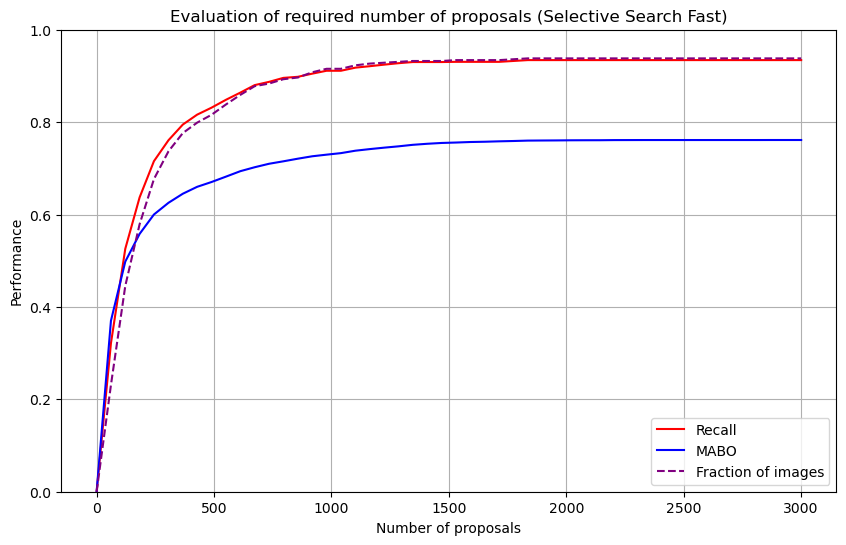


Selective Search Fast optimal number of proposals: 673
- Recall: 0.880
- MABO: 0.702
- Image coverage: 0.878

Evaluating Edge Boxes...


532it [13:09,  1.48s/it]


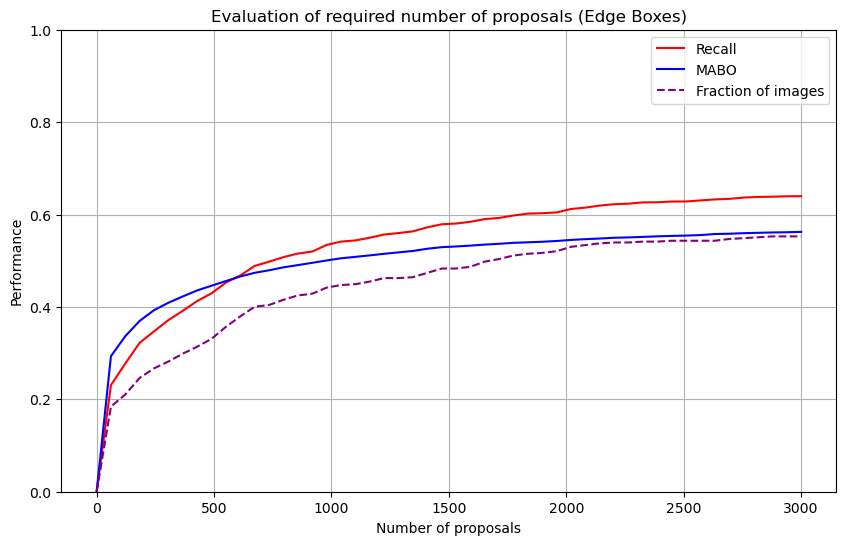


Edge Boxes optimal number of proposals: 1836
- Recall: 0.602
- MABO: 0.540
- Image coverage: 0.515


In [65]:
# Set paths
ROOT_DIR = '/Users/zhangyu/Downloads/Potholes'
IMAGES_DIR = os.path.join(ROOT_DIR, 'annotated-images')

# Load dataset
train_images, train_annotations = load_dataset(ROOT_DIR)
print(f"Loaded {len(train_images)} training images")

# Initialize generator and evaluator
generator = ProposalGenerator()
evaluator = ProposalEvaluator()

# Evaluate Selective Search
print("\nEvaluating Selective Search Fast...")
recalls_ss, mabos_ss, fractions_ss = evaluator.evaluate_proposals(
    train_images, train_annotations, generator.selective_search_fast)

# Plot SS results
plt.figure(figsize=(10, 6))
plt.title('Evaluation of required number of proposals (Selective Search Fast)')
plt.grid(True)
plt.plot(evaluator.proposal_steps, recalls_ss, label='Recall', color='red')
plt.plot(evaluator.proposal_steps, mabos_ss, label='MABO', color='blue')
plt.plot(evaluator.proposal_steps, fractions_ss, '--', label='Fraction of images', color='purple')
plt.xlabel('Number of proposals')
plt.ylabel('Performance')
plt.legend()
plt.ylim(0, 1)
plt.show()

# Print SS optimal numbers
min_proposals = 500  
max_proposals = 2000 

# Only consider proposals that are within a reasonable range
valid_indices = np.where((evaluator.proposal_steps >= min_proposals) & 
                        (evaluator.proposal_steps <= max_proposals))[0]
valid_recalls = recalls_ss[valid_indices]
valid_steps = evaluator.proposal_steps[valid_indices]

# Select the optimal point based on the balance between recall and proposal numbers
# Use recall/log(proposals) as a metric to balance recall and proposal numbers
efficiency = valid_recalls / np.log(valid_steps)
optimal_idx = valid_indices[np.argmax(efficiency)]
optimal_proposals = evaluator.proposal_steps[optimal_idx]

print(f"\nSelective Search Fast optimal number of proposals: {optimal_proposals}")
print(f"- Recall: {recalls_ss[optimal_idx]:.3f}")
print(f"- MABO: {mabos_ss[optimal_idx]:.3f}")
print(f"- Image coverage: {fractions_ss[optimal_idx]:.3f}")

# Evaluate Edge Boxes
print("\nEvaluating Edge Boxes...")
recalls_eb, mabos_eb, fractions_eb = evaluator.evaluate_proposals(
    train_images, train_annotations, generator.edge_boxes)

# Plot Edge Boxes results
plt.figure(figsize=(10, 6))
plt.title('Evaluation of required number of proposals (Edge Boxes)')
plt.grid(True)
plt.plot(evaluator.proposal_steps, recalls_eb, label='Recall', color='red')
plt.plot(evaluator.proposal_steps, mabos_eb, label='MABO', color='blue')
plt.plot(evaluator.proposal_steps, fractions_eb, '--', label='Fraction of images', color='purple')
plt.xlabel('Number of proposals')
plt.ylabel('Performance')
plt.legend()
plt.ylim(0, 1)
plt.show()

# Print Edge Boxes optimal numbers
valid_recalls = recalls_eb[valid_indices]
efficiency = valid_recalls / np.log(valid_steps)
optimal_idx = valid_indices[np.argmax(efficiency)]
optimal_proposals = evaluator.proposal_steps[optimal_idx]

print(f"\nEdge Boxes optimal number of proposals: {optimal_proposals}")
print(f"- Recall: {recalls_eb[optimal_idx]:.3f}")
print(f"- MABO: {mabos_eb[optimal_idx]:.3f}")
print(f"- Image coverage: {fractions_eb[optimal_idx]:.3f}")